20240517

sarahfong

# Goal

- identify what motifs are gained/lost when MPRA tiles gain/lose activity (above/below shuffled dist)?

In [1]:
LOCAL = False

import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")


if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
    RE_MAPS = os.path.join(RE, "enh_maps")
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/fongsl/projects/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"

# nomination dataframe
NOMS = os.path.join(PATH, "GABA_GLUT_DF.for.noms.tsv")

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [3]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

MPRA = config[section]["delta.mpra_richa"]
DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

FASTA = config[section]["fasta"]

TILE_BED = config[section]["tile_bed"]
ENH_BED = config[section]["enh_bed"]

GREAT_GENE_TSV = config[section]["great_nearest"]
META_DATA = config[section]["metadata"]

SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
VISTA = config[section]["vista"]

SUPPORT = config[section]["support"] # neighboring tile support
TFBS = config["tfbs2"]["vierstra.motif.loc.nored"] # TFBS archetypes where score is in 95% of motif scores, binned by length, no redundants
    # i.e. the strongest of the motif matches. 

LOSSES_AND_GAINS = config["tfbs2"]["vierstra.motif.loc.nored.loss.gain"]  # write the tiles with losses and gains only. 

RE_SUPPORT_MAPS = os.path.join(RE_MAPS, "support_neighbor_maps")

COEFFS = os.path.join(RE, 'TF.Lasso.Coeff.tsv')
config["tfbs2"]["vierstra.motif.lasso_coeffs"]= COEFFS
crw.write(config, cfn)

# load all the data

In [4]:
tf = pd.read_csv(TFBS, sep='\t')
tf["name"] = tf["#chr"] + ":" + tf["start_tile"].map(str) + "-" + tf["end_tile"].map(str)
#tf.rename(columns={'tile.coor':"name"}, inplace=True)

tf.head()

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,num_models,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name
0,chr1,10117,10387,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,1,14,False,269,283,True,10.7289,chr1:10117-10387
1,chr1,10133,10403,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,253,267,True,10.7289,chr1:10133-10403
2,chr1,10137,10407,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,249,263,True,10.7289,chr1:10137-10407
3,chr1,10153,10423,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,233,247,True,10.7289,chr1:10153-10423
4,chr1,10157,10427,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,229,243,True,10.7289,chr1:10157-10427


In [5]:
loss_n_gain = pd.read_csv(LOSSES_AND_GAINS, sep='\t')
loss_n_gain.head()

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,...,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name,tile.order,enh.name
0,chr1,10213,10483,chr1,10502,10518,NR/16,11.5888,-,THA_HUMAN.H11MO.0.C,...,0,16,False,289,305,True,10.7017,chr1:10217-10487,14.0,enh.0
1,chr1,1692062,1692332,chr1,1692343,1692358,MAF,10.4898,-,MAFK_bZIP_4,...,0,15,False,281,296,True,10.3890,chr1:1692062-1692332,4.0,enh.1
2,chr1,1693213,1693483,chr1,1693496,1693513,KLF/SP/2,15.0017,+,KLF12_HUMAN.H11MO.0.C,...,0,17,False,283,300,True,13.4296,chr1:1693220-1693490,3.0,enh.2
3,chr1,2440248,2440518,chr1,2440219,2440229,ETS/1,11.9618,+,GABPA_MOUSE.H11MO.0.A,...,0,10,False,-29,-19,True,10.5357,chr1:2440248-2440518,3.0,enh.3
4,chr1,2440248,2440518,chr1,2440218,2440229,ETS/2,11.6678,+,ETS1_MOUSE.H11MO.0.A,...,0,11,False,-30,-19,True,11.6052,chr1:2440248-2440518,3.0,enh.3


In [6]:
tf[['#chr', 'start_tile', 'end_tile',
 '#chr_arch', 'start_arch', 'end_arch',
 'group','overlap', 'motif_len', 'motif_overlap',]].head(25)

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,overlap,motif_len,motif_overlap
0,chr1,10117,10387,chr1,10386,10400,NR/3,1,14,False
1,chr1,10133,10403,chr1,10386,10400,NR/3,14,14,True
2,chr1,10137,10407,chr1,10386,10400,NR/3,14,14,True
3,chr1,10153,10423,chr1,10386,10400,NR/3,14,14,True
4,chr1,10157,10427,chr1,10386,10400,NR/3,14,14,True
5,chr1,10173,10443,chr1,10386,10400,NR/3,14,14,True
6,chr1,10177,10447,chr1,10386,10400,NR/3,14,14,True
7,chr1,10193,10463,chr1,10386,10400,NR/3,14,14,True
8,chr1,10197,10467,chr1,10386,10400,NR/3,14,14,True
9,chr1,10213,10483,chr1,10386,10400,NR/3,14,14,True


## library coordinates

In [7]:
lib = pd.read_csv(ENH_BED, sep='\t')
lib.head()

,#chr,start.tile,end.tile,coor,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order,name
0,chr1,10057.0,10327.0,chr1:10057-10327,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,0.0,chr1:10057-10327
1,chr1,10077.0,10347.0,chr1:10077-10347,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,1.0,chr1:10077-10347
2,chr1,10097.0,10367.0,chr1:10097-10367,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,2.0,chr1:10097-10367
3,chr1,10117.0,10387.0,chr1:10117-10387,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,3.0,chr1:10117-10387
4,chr1,10133.0,10403.0,chr1:10133-10403,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,4.0,chr1:10133-10403


## MPRA activity summary

In [8]:
mpra = pd.read_csv(DELTA_ACTIVITY_Z, sep='\t')
mpra.head()

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.699699,-1.696544,-1.003154,0.119390,0.923032,False
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.493535,0.306682,False
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.728743,0.137425,False
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.364764,0.437989,False
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.801537,0.096076,False


## MPRA reps activity

In [9]:
# get per rep activity
usecols = ['name',
            'gaba_1',
            'gaba_2',
            'gaba_3',
            'glut_1',
            'glut_2',
            'glut_3',
            'fdr_bool'
           ]
reps = pd.read_csv(SIG_ACTIVITY_Z, sep='\t', usecols=usecols)
reps.head()

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,fdr_bool
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,False
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,False
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,False
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,False
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,False


## support neighbors

In [10]:
support = pd.read_csv(SUPPORT, sep='\t')

# enh_ids with neighbor support
supported_enhid = support.loc[support["neighbor_either_label"]!=False, "enh.name"].unique()
print(len(supported_enhid))
support

1740


,name,tile.order,support_dif,support_dif_code,support_dif_name,neighbor_dif,neighbor_gaba_label,neighbor_glut_label,enh.name,neighbor_either_label
0,chr15:58748908-58749178,0.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
1,chr15:58748928-58749198,1.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
2,chr15:58748948-58749218,2.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
3,chr15:58748968-58749238,3.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
4,chr15:58748988-58749258,4.0,0,0,NaN,NaN,NaN,NaN,enh.566,None.None
...,...,...,...,...,...,...,...,...,...,...
42171,chr19:44891616-44891886,134.0,0,0,NaN,NaN,NaN,NaN,enh.810,None.None
42172,chr19:44891636-44891906,135.0,0,0,NaN,NaN,NaN,NaN,enh.810,None.None
42173,chr19:44891656-44891926,136.0,0,0,NaN,NaN,NaN,NaN,enh.810,None.None
42174,chr19:44891676-44891946,137.0,1,10,cat-only,NaN,NaN,NaN,enh.810,None.None


## merge library enh and tile order w/ MPRA activity values

In [11]:
# merge library and MPRA activity, conserve library annotations (even when oligo doesn't have activity score)
lib_mpra = pd.merge(lib[["name", "enh.name", "tile.order"]], mpra, how="left") 
lib_mpra = pd.merge(lib_mpra, reps, how="left") # merge replicate measures, too

lib_mpra['sig_n_dif_n_bs'] = lib_mpra["sig"] + lib_mpra["celltype_dif"] + lib_mpra["bs"] # add combination of 3 sig measures

# add support
lib_mpra = pd.merge(lib_mpra , 
                    support, 
                    how="left").drop_duplicates()

tf = pd.merge(lib[["name", "enh.name", "tile.order"]], tf, how="left") # add enhancer name, tile information to the tf
lib_mpra

,name,enh.name,tile.order,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,...,glut_3,fdr_bool,sig_n_dif_n_bs,support_dif,support_dif_code,support_dif_name,neighbor_dif,neighbor_gaba_label,neighbor_glut_label,neighbor_either_label
0,chr1:10057-10327,enh.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,None.None
1,chr1:10077-10347,enh.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,None.None
2,chr1:10097-10367,enh.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,None.None
3,chr1:10117-10387,enh.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,None.None
4,chr1:10133-10403,enh.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,None.None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44039,chrY:19745320-19745590,enh.1825,58.0,activating,False,True,True,1.180058,0.583318,0.596740,...,0.562037,True,2,2.0,110.0,sig-n-cat,enh.1825.dif.1,enh.1825.gaba.0,NaN,enh.1825.gaba.0.None
44040,chrY:19745340-19745610,enh.1825,59.0,False,False,True,False,1.002419,0.364112,0.638307,...,0.304934,True,1,1.0,100.0,sig-only,enh.1825.dif.1,enh.1825.gaba.0,NaN,enh.1825.gaba.0.None
44041,chrY:19745360-19745630,enh.1825,60.0,False,False,False,False,1.140756,0.618690,0.522067,...,1.129509,False,0,0.0,0.0,NaN,enh.1825.dif.1,NaN,NaN,None.None
44042,chrY:19745380-19745650,enh.1825,61.0,False,False,False,False,0.818851,0.399314,0.419537,...,0.622282,False,0,0.0,0.0,NaN,enh.1825.dif.1,NaN,NaN,None.None


In [12]:
loss_n_gain.sort_values(by="name")

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,...,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name,tile.order,enh.name
1096,chr10,101031717,101031987,chr10,101031964,101031977,NR/1,10.5399,+,HNF4G_MA0484.1,...,0,13,False,247,260,True,10.5229,chr10:101031647-101031917,27.0,enh.209
1097,chr10,101031717,101031987,chr10,101031951,101031967,MZF1,11.5076,+,ZN816_HUMAN.H11MO.0.C,...,0,16,False,234,250,True,10.7017,chr10:101031647-101031917,27.0,enh.209
1095,chr10,101031667,101031937,chr10,101031631,101031648,KLF/SP/2,13.6199,+,KLF5_MOUSE.H11MO.0.A,...,0,17,False,-36,-19,True,13.4296,chr10:101031737-101032007,27.0,enh.209
1098,chr10,101031757,101032027,chr10,101031745,101031756,KLF/SP/1,11.7105,-,KLF4_HUMAN.H11MO.0.A,...,0,11,False,-12,-1,True,11.6052,chr10:101031757-101032027,28.0,enh.209
1099,chr10,101031777,101032047,chr10,101032064,101032071,Ebox/CACCTG,11.4085,+,ZEB1_MA0103.3,...,0,7,False,287,294,True,10.1069,chr10:101031777-101032047,30.0,enh.209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9010,chr5,138465277,138465547,chr5,138465254,138465265,ZFX,12.0790,-,ZFX_MOUSE.H11MO.0.B,...,0,11,False,-23,-12,True,11.6052,shuffle_46_chr5:138465270-138465540,100.0,enh.1420
6879,chr21,33915712,33915982,chr21,33915680,33915693,ZIC,10.8674,-,ZIC3_HUMAN.H11MO.0.B,...,0,13,False,-32,-19,True,10.5229,shuffle_51_chr21:33915711-33915981,55.0,enh.1083
4872,chr19,42268123,42268393,chr19,42268099,42268113,NR/3,10.8202,-,PPARG_HUMAN.H11MO.0.A,...,0,14,False,-24,-10,True,10.7289,shuffle_60_chr19:42268123-42268393,15.0,enh.806
4873,chr19,42268123,42268393,chr19,42268106,42268117,NR/19,12.2740,-,NR1D1_HUMAN.H11MO.0.B,...,0,11,False,-17,-6,True,11.6052,shuffle_60_chr19:42268123-42268393,15.0,enh.806


In [13]:
tf_ = pd.concat([tf, loss_n_gain])

# find largest differences in consecutive MPRA oligos

In [14]:
def computeActivityDif(df, enh_id):
    """compute difference per enhancer using pandas .diff() function. 
        For this to work, dataframe must be sorted from first to last tile for each enhancer
    """
    enhdf = df.loc[df["enh.name"]==enh_id].copy()  #enh id 
    diff = enhdf[["gaba", "glut", "delta.gaba-glut"]].diff() # compute differences between two rows in a column. Is NaN when one or both rows are NaN
    diff.columns=['inter.tile.diff.gaba','inter.tile.diff.glut', "inter.tile.diff.delta.gaba-glut"] # rename column of differences
    return pd.merge(enhdf, diff, left_index=True, right_index=True)

In [15]:
#  per enhancer, compute difference between tiles
results = {}
for enhid in lib_mpra["enh.name"].unique():
    results[enhid] = computeActivityDif(lib_mpra, enhid) # add to dictionary
    
lib_mpra_dif=pd.concat(results.values()) # combine dictionary results into new data

<Axes: xlabel='inter.tile.diff.gaba', ylabel='Count'>

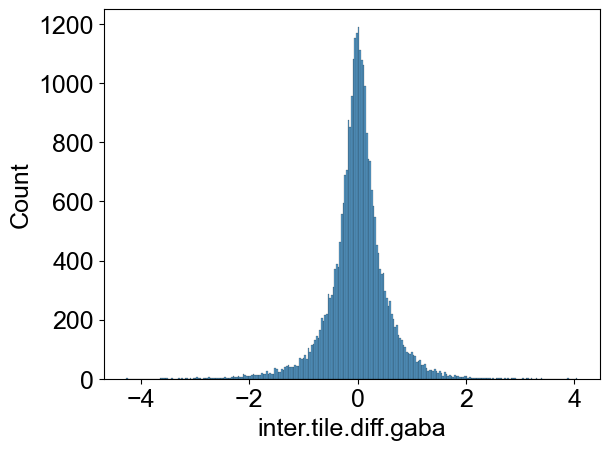

In [16]:
x = "inter.tile.diff.gaba"
data=lib_mpra_dif
sns.histplot(x=x, data=data)

# evaluate tfs that significantly associate w/ activity

### get dataframe, define plotting scripts

In [18]:
def getLongFormEnhInfo(df, mpra_celltype):
    """ return dataframes for plotting gaba/glut longform tile activity and significance
    """
    # do some data formatting, sorting`
    df["tile.order"] = df["tile.order"].astype(int)
    df = df.sort_values(by="tile.order")

    # get dataframe of tile.order x significant differences
    sd = pd.melt(df, id_vars="tile.order",
                 value_vars="sig_n_dif_n_bs",
                 value_name="support"
                 ).drop_duplicates().reset_index()
    
    # new variable
    VAR_NAME = "Mean z-score ratio"

    # get replicates of gaba, glut and melt into longform
    if mpra_celltype == "gaba": 
        cols = ["gaba_1", "gaba_2", "gaba_3"]
        
    elif mpra_celltype =="glut":
        cols = ["glut_1", "glut_2", "glut_3"]

    # longform GABA
    longform = pd.melt(df, id_vars="tile.order",
                            value_vars=cols,
                            value_name=VAR_NAME).drop_duplicates().reset_index()

   
    # add back significance column
    longform = pd.merge(longform, sd, how="left", left_on="tile.order",
                             right_on='tile.order').drop(columns=["index_x", "index_y"])
    
    
    # change tile.order datatype
    longform["tile.order"]= longform["tile.order"].astype(int)
    
    # fill any missing data w zeros
    longform[VAR_NAME]=longform[VAR_NAME].fillna(0)
    
    return longform, VAR_NAME

def plot_lineplot(longform_gaba, longform_glut, var_name, out, enh_id, gene_name, plot_support_annot=None):
    sns.set(font_scale=1.4, style='white')
    if len(set(longform_gaba['tile.order'])) > 20:
        fig, ax = plt.subplots(figsize=(12, 4))
    else:
        fig, ax = plt.subplots(figsize=(8, 4))

    # print max scores
    max_gaba, max_glut = longform_gaba[var_name].max(),\
    longform_glut[var_name].max()

    # min scores
    min_gaba, min_glut = longform_gaba[var_name].min(),\
    longform_glut[var_name].min()

    # get max of two for plotting purposes
    max_of_max = max(max_gaba, max_glut)
    min_of_min = min(min_gaba, min_glut)

    if max_of_max < 3.2:
        ymax = 3.2
        ymin = (ymax*-1) - 1
    else:
        ymax = max_of_max + 1
        ymin = (ymax*-1) - 1

    print('max gaba', max_gaba, "max_glut", max_glut)

    # plot longform gaba across enhancer
    sns.pointplot(x="tile.order", y=var_name, data=longform_gaba.fillna(0),
                  label="gaba",
                  join=False,
                  errorbar=("sd"),
                  color="orange", ax=ax)
    plt.setp(ax.collections, alpha=.3)  # alpha
    x="tile.order"
    data=longform_glut.fillna(0)

    # plot longform glut activity across enhancer
    sns.pointplot(x="tile.order", y=var_name, data=data,
                  label="glut",
                  join=False,
                  errorbar=("sd"),
                  color="blue", 
                 # ax=ax
                 )
    plt.setp(ax.collections, alpha=.3)  # alpha

    ax.axhline(0, ls="--", color="grey") # zero line
    ax.set(title=enh_id)
    
    # Set major ticks for x axis
    ntiles = longform_gaba['tile.order'].max()
    if ntiles >= 100:
        segment = 10
    else:
        segment = 5

    major_xticks = np.arange(0, ntiles, segment)
    ax.set_xticks(major_xticks)

    #ax2.set_yticklabels("")
    
    # legend
    ax.legend(title='key', frameon=False,
              bbox_to_anchor=(0.75, -0.25))
    #ax2.legend(title=marker_title, bbox_to_anchor=(1, -0.25), frameon=False)

    # save figure
    plt.savefig(out, bbox_inches="tight")

    plt.show()
    plt.close()
    

def neighborActivity(longform_glut, longform_gaba, neighbor_support):
    glut_s = longform_glut.loc[longform_glut["tile.order"].isin(neighbor_support)].groupby(
        'tile.order')['Mean z-score ratio'].mean().reset_index()
    glut_s.rename(columns={"Mean z-score ratio": "glut.mean"}, inplace=True)

    gaba_s = longform_gaba.loc[longform_gaba["tile.order"].isin(neighbor_support)].groupby(
        'tile.order')['Mean z-score ratio'].mean().reset_index()
    gaba_s.rename(columns={"Mean z-score ratio": "gaba.mean"}, inplace=True)

    # print(pd.merge(glut_s, gaba_s ))
    # merge the mean activity of the gaba and glut tiles
    return pd.merge(glut_s, gaba_s)

get set of credible enhancer ids to look up

## OLS + Lasso functions

In [19]:
def runOLS(table_tf, table_df, cl):
    """run OLS"""
    test = pd.merge(table_tf, table_df, left_index=True,
                    right_index=True).drop_duplicates()  # merge information together
    # replace troublesome characters
    test.columns = [i.replace("/", "_") for i in test.columns]
    # replace troublesome characters
    test.columns = [i.replace("-", "_") for i in test.columns]
    test = sm.add_constant(test)  # add a constant

    # make vector of terms
    terms = cl + " ~ " + " + ".join([f"C({i})" for i in test.columns[1:-1]])
    print(terms)

    # make OLS model
    mod = ols(terms, data=test)
    res = mod.fit()
    print(res.summary())


def runLasso(table_tf, table_df, cl):
    """run lasso regression, alpha=0.1, I haven't optimized alpha..."""

    test = pd.merge(table_tf, table_df, left_index=True,
                    right_index=True).drop_duplicates()  # merge information together

    X = test[test.columns[:-1]]
    y = test[test.columns[-1]]

    clf = linear_model.Lasso(alpha=0.1)
    clf.fit(X, y)

    features = {}
    for i, j in zip(clf.feature_names_in_, clf.coef_):
        if j != 0:  # print coefficients that aren't zero
            print(i+' = ' + str(round(j, 3)))
            features[i] = j
    return features


def clusterMap(table_tf, table_df, feats, enhid, title):
    """clustermap of tf locations"""

    sns.set(font_scale=1.4, style='white')
    table_tf.index = table_tf.index.astype(int)  # set tiles as int
    data = table_tf[feats.keys()].T

    # turn inactivating values negative for heatmape
    for key, value in feats.items():
        # apply the coefficient to the loci that match the tfbs
        data.loc[key] = data.loc[key].apply(lambda x: value if x > 0 else None)

    # hide data that is not in MPRA.
    not_in_mpra = list(set(data.columns).difference(set(table_df.index)))
    for i in not_in_mpra:
        data[i] = data[i].apply(lambda x: 0)

    if data.shape[0] > 1:
        cg = sns.clustermap(data.fillna(0), cmap="bwr", center=0, col_cluster=False, square=True,
                            # annot=True,
                            mask=data == 0,
                            figsize=(16, 3),
                            row_linkage=None, cbar=False, annot_kws=dict(clip_on=False))
        cg.ax_row_dendrogram.set_visible(False)
        cg.cax.set_visible(False)
        cg.fig.suptitle(title)
        cg.set_xlim = (0, table_tf.shape[0])
        cg.set_ylabel = ""

    else:
        fig, ax = plt.subplots(figsize=(16, 3))
        cg = sns.heatmap(data.fillna(0), cmap="bwr", center=0,
                         square=True,
                         # annot=True,
                         mask=data == 0)
        ax.set(xlim=(0, table_tf.shape[0]),
               ylabel="",
               title=title
               )
    outfn = enhid + "." + title + ".pdf"
    out = os.path.join(RE_SUPPORT_MAPS, outfn)
    plt.savefig(out, bbox_inches="tight")

## do lasso regression

In [20]:
def lassoActive(enhid, lib_mpra_dif,tf, plot=False):
    """compute coefficients per enhancer, cell-type active label 
        before running: Require support from neighbors to compute coefficients that contribute to cell line activity changes.

    """
    cols = ["enh.name",
            "tile.order",
            "group",
            "motif_overlap",
            "start_motif",
            ]

    enhdf = lib_mpra_dif.loc[lib_mpra_dif["enh.name"] == enhid].copy()
    enhtf = tf.loc[tf["enh.name"] == enhid,
                   cols].drop_duplicates().reset_index(drop=True).copy()

    # annotate when motifs are broken up by tiling (i.e. when motif overlap is false and motif is not fully embedded in tile. )
    enhtf["motif_nooverlap"] = enhtf["motif_overlap"].apply(
        lambda x: False if x is True else True)

    if plot is True:

        # for plotting line graph and finding support neighborhoods
        gabadf, var_name = getLongFormEnhInfo(
            enhdf, "gaba")

        # for plotting line graph and finding support neighborhoods
        glutdf, var_name = getLongFormEnhInfo(
            enhdf, "glut")

        out_lineplot =  os.path.join(RE_SUPPORT_MAPS, enhid+".pdf")
        plot_lineplot(gabadf, glutdf, var_name,
                     out_lineplot, enhid, "gene_name")

    cl_feats = {"gaba": {},
                "glut": {}}

    for celltype in ["glut", "gaba"]:
        
        # motifs whose loss produces activity differences, or motifs whose presence produces activity in that cell type
        dif_act_tests = [("motif_nooverlap", f"inter.tile.diff.{celltype}"),
                         ("motif_overlap", celltype)
                         ]
        feats = {}  # collect both motif overlapping and non-overlapping coefficient information
        for tf_overlapcol, activity_col in dif_act_tests:

            # make tables for Lasso regression

            # X = table_tf - rows = tiles, columns = TFBS, values = 1/0 TFBS overlaps tile fully/not fully
            table_tf = pd.pivot_table(enhtf.loc[enhtf[tf_overlapcol]==True],
                                      columns="group", index="tile.order", values=tf_overlapcol).fillna(0)

            # Y = MPRA celltype activity
            table_df = pd.pivot_table(enhdf[["enh.name", "tile.order", activity_col]],
                                      columns="enh.name", index="tile.order", values=activity_col).fillna(0)

            table_df.rename(columns={enhid: activity_col}, inplace=True)

            # runOLS(table_tf, table_df, cl) # demoted. Run Lasso regression bc lots of variables.

            # lasso regression is more focuesd than OLS.

            print(table_tf.shape, table_df.shape)
            #if table_tf.shape[0] > 0:  # if there are tfs

            # return dictionary of coefficients
            try:
                features = runLasso(table_tf, table_df, celltype)
                

                if len(features.keys()) > 0:  # if significant coefficients
                    feats[tf_overlapcol] = features
                    print(tf_overlapcol, "sig coefficients", features.keys())

                    # if plot is true, plot TF map
                    if plot is True:
                        clusterMap(table_tf, table_df, features, enhid,
                                   tf_overlapcol + "." + celltype)
            except:
                print("no sig coeffs", enhid,  list(table_tf))
                feats[tf_overlapcol] = {}
        
        cl_feats[celltype] = feats  # add features dict to cell type features dict
        
        if (table_tf.shape[0] > 0):
            # merge enhancer and tf information
            t = pd.merge(enhdf, table_tf, left_on="tile.order",
                         right_index=True).drop_duplicates()
           
        else:
            t = enhdf
        # return significant lasso coefficients, mergedtable of enhancer activity and tf motifs
    return cl_feats, t

# Dev - enhancer 280

## plot one enhancer

In [21]:
enhid = "enh.428"
activity_col ="glut"
cols = ["enh.name",
        "tile.order",
        "group",
        "motif_overlap",
        "start_motif",
        ]

enhdf = lib_mpra_dif.loc[lib_mpra_dif["enh.name"] == enhid].copy()
enhtf = tf.loc[tf["enh.name"] == enhid,
               cols].drop_duplicates().reset_index(drop=True)
enhtf["motif_nooverlap"] = enhtf["motif_overlap"].apply(
    lambda x: False if x is True else True)

tf_overlapcol = "motif_overlap"

# X = table_tf - rows = tiles, columns = TFBS, values = 1/0 TFBS overlaps tile fully/not fully
table_tf = pd.pivot_table(enhtf.loc[enhtf[tf_overlapcol]==True],
                          columns="group", index="tile.order", values=tf_overlapcol).fillna(0)

table_df = pd.pivot_table(enhdf[["enh.name", "tile.order", activity_col]],
                                      columns="enh.name", index="tile.order", values=activity_col).fillna(0)

table_df.shape[0]

5

max gaba 1.159555610813457 max_glut 2.316551036076503


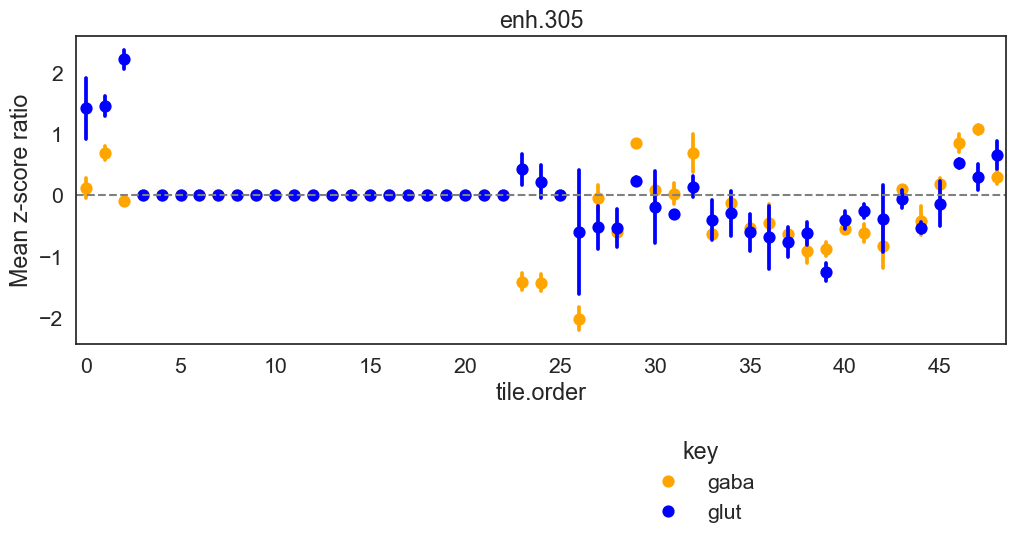

(19, 23) (25, 1)
(49, 24) (28, 1)
E2F/2 = 0.204
EGR = 0.334
ETS/2 = 0.315
HINFP1/1 = -0.129
motif_overlap sig coefficients dict_keys(['E2F/2', 'EGR', 'ETS/2', 'HINFP1/1'])
{'motif_overlap': {'E2F/2': 0.20354580748472897, 'EGR': 0.3343517728759677, 'ETS/2': 0.31462460162558176, 'HINFP1/1': -0.12859576800654976}}
(19, 23) (25, 1)
ETS/1 = 0.815
GC-tract = -0.306
KLF/SP/2 = -0.001
motif_nooverlap sig coefficients dict_keys(['ETS/1', 'GC-tract', 'KLF/SP/2'])
(49, 24) (28, 1)
NR/15 = -0.042
motif_overlap sig coefficients dict_keys(['NR/15'])
{'motif_nooverlap': {'ETS/1': 0.8151183971175112, 'GC-tract': -0.3059815001890099, 'KLF/SP/2': -0.0008124050735628165}, 'motif_overlap': {'NR/15': -0.04180651010136224}}
chr11:118572180-118572450


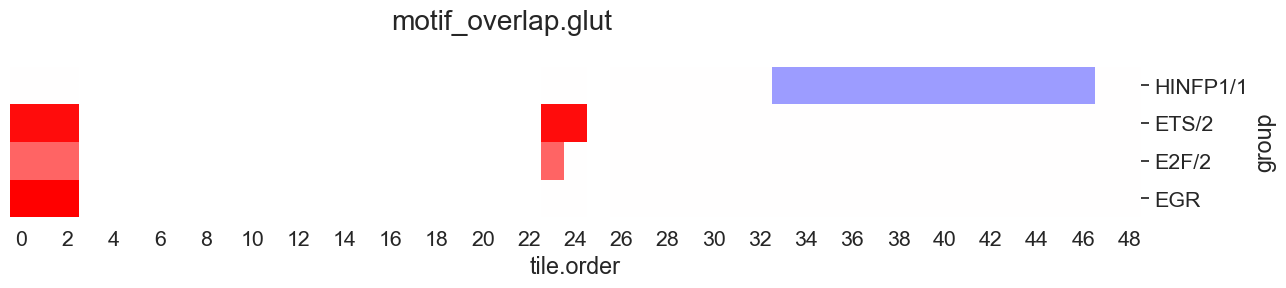

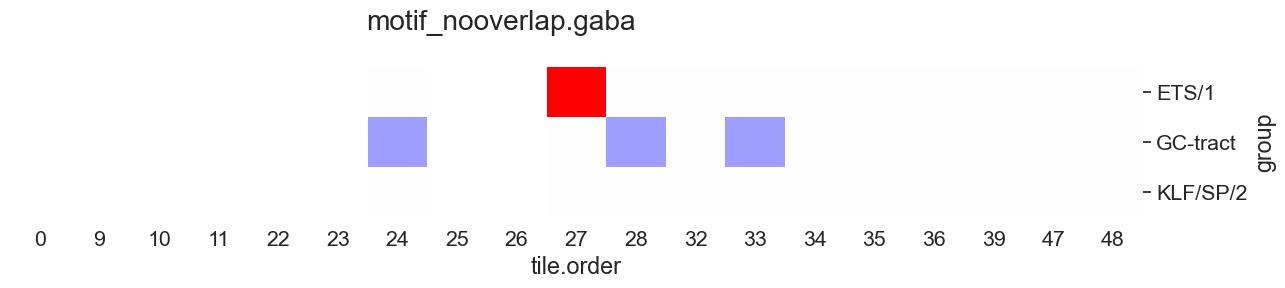

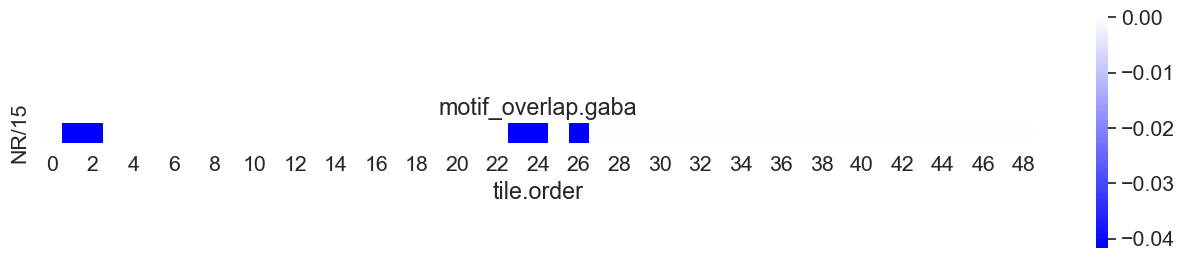

In [33]:
CELLTYPE = "glut"
enhid =  'enh.305' #"enh.280"
n = 0
supportenh = support.loc[(support["enh.name"] == enhid) &
                         (support[f"neighbor_{CELLTYPE}_label"] == True)]

features_d, enhdf_d = lassoActive(enhid, lib_mpra_dif, tf_, 
            plot=True)

print(enhdf_d["name"].iloc[0])

# estimate activity ~ TFs coefficient for each locus, active AND repressive elements, per cell type

In [ ]:
COEFFS = os.path.join(RE, 'TF.Lasso.Coeff.tsv')

if os.path.exists(COEFFS) is False:

    # parse every enhancer id, measure significant coefficients of activity
    coeffs, data = {}, {}

    # for n, enhid in enumerate(np.random.choice(supported_enhid, size=200)): # for dev
    
    for n, enhid in enumerate(supported_enhid):
        print(enhid)
    
        plot = False
        features, enh_df = lassoActive(enhid, lib_mpra_dif, tf_, plot=plot)
        coeffs[enhid] = features
        data[enhid] = enh_df
        #if n == 100:
            #break

    # combine coefficient information together. 
    cfs = {}
    val = 0
    for enhid, f in coeffs.items():
        val+=1
        for cell_type, overlap_dict in f.items():
            val+=1
            for tf_overlap, tf_coeff in overlap_dict.items():
                val+=1
                #print(cell_type, tf_overlap)
            
                test = pd.DataFrame(tf_coeff.items())
            
                if len(list(test))>0:
                    test[2] = enhid
                    test[3]=cell_type
                    test[4] = tf_overlap
                    cfs[val] = test

    # make dataframe of coefficient estimates
    cf = pd.concat(cfs.values())
    cf.columns=["tf","enh.coeff", 'enh.name', "cell_type", "overlap_type"]
    print(set(cf['overlap_type']), cf.shape)

    # write dataframe
    cf.to_csv(COEFFS, sep='\t', index=False)
else:
    cf=pd.read_csv(COEFFS, sep='\t')

## add coefficient information to TFs

In [19]:
coeff_col_names= ['enh.name', 'group', 'gaba-motif_overlap', 'glut-motif_overlap', 'gaba-motif_nooverlap', 'glut-motif_nooverlap']
# pivot coefficient data to add back to dataframe. Annotate credible elements
a = pd.pivot(cf, index=["enh.name", "tf"], columns=["cell_type", "overlap_type"], values="enh.coeff").reset_index()
# flatten multilevel columns
a.columns = a.columns.get_level_values(0)

# rename columnsn to harmonize with tf dataframe
a.columns = coeff_col_names

# merge!
tf_coeffs = pd.merge(tf_, a, how="left").drop_duplicates()


## Genome browser track - write bed file of sig TFs per condition

In [164]:
for col in coeff_col_names[-4:]:
    tf_coeff_cols = ["#chr", "start_arch", "end_arch", "group", col, "strand"]

    # filtered dataframe for either no-overlapping coefficients (loss break leads to change in activity) or for only overlapping coefficients
    if "nooverlap" in col:
        overlap = False
    else:
        overlap=True
    
    # annotate necessary and sufficient
    tf_coeff_col = tf_coeffs.loc[(~tf_coeffs[col].isna())&
                                (tf_coeffs["motif_overlap"]==overlap),
                                tf_coeff_cols].drop_duplicates().copy()
    out = os.path.join(RE, f"track.tfbs.coeff.{col}.bed")
    tf_coeff_col[["start_arch", "end_arch"]] = tf_coeff_col[["start_arch", "end_arch"]].astype(int)
    tf_coeff_col["start_arch_"], tf_coeff_col["end_arch_"] = tf_coeff_col["start_arch"], tf_coeff_col["end_arch"]
    tf_coeff_col["itemRgb"] = "255,0,0" #red
    tf_coeff_col.loc[tf_coeff_col[col]<0,'itemRgb'] =  "0,0,255"#blue
    tf_coeff_col.to_csv(out, sep='\t', index=False, header=False)
    print(out)


/wynton/group/ahituv/fongsl/projects/biomarin/results/track.tfbs.coeff.gaba-motif_overlap.bed
/wynton/group/ahituv/fongsl/projects/biomarin/results/track.tfbs.coeff.glut-motif_overlap.bed
/wynton/group/ahituv/fongsl/projects/biomarin/results/track.tfbs.coeff.gaba-motif_nooverlap.bed
/wynton/group/ahituv/fongsl/projects/biomarin/results/track.tfbs.coeff.glut-motif_nooverlap.bed


In [1]:
%%bash
ls /wynton/group/ahituv/data/dna/hg38

1kg
ancestral
chromosomes
clinvar
gencode
gwas_catalog
hg38.2bit
hg38.chrom.sizes
hg38.fa
hg38.fa.fai
hg38ToHg19.over.chain.gz
hg38ToHs1.over.chain.gz
kmers
multiz30way
phastCons
README
vastdb


In [28]:
lib["enh.len"] = lib["end.enh"]-lib["start.enh"]


,#chr,start.tile,end.tile,coor,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order,name,enh.len
0,chr1,10057.0,10327.0,chr1:10057-10327,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,0.0,chr1:10057-10327,506.0
1,chr1,10077.0,10347.0,chr1:10077-10347,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,1.0,chr1:10077-10347,506.0
2,chr1,10097.0,10367.0,chr1:10097-10367,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,2.0,chr1:10097-10367,506.0
3,chr1,10117.0,10387.0,chr1:10117-10387,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,3.0,chr1:10117-10387,506.0
4,chr1,10133.0,10403.0,chr1:10133-10403,chr1,10057.0,10563.0,chr1:10057-10563,enh.0,4.0,chr1:10133-10403,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...
44039,chrY,19745320.0,19745590.0,chrY:19745320-19745590,chrY,19744097.0,19745670.0,chrY:19744097-19745670,enh.1825,58.0,chrY:19745320-19745590,1573.0
44040,chrY,19745340.0,19745610.0,chrY:19745340-19745610,chrY,19744097.0,19745670.0,chrY:19744097-19745670,enh.1825,59.0,chrY:19745340-19745610,1573.0
44041,chrY,19745360.0,19745630.0,chrY:19745360-19745630,chrY,19744097.0,19745670.0,chrY:19744097-19745670,enh.1825,60.0,chrY:19745360-19745630,1573.0
44042,chrY,19745380.0,19745650.0,chrY:19745380-19745650,chrY,19744097.0,19745670.0,chrY:19744097-19745670,enh.1825,61.0,chrY:19745380-19745650,1573.0


## is coefficient magnitude correlated w/ enh len, n tiles measured? 

In [103]:
tile_counts = lib_mpra.loc[(~lib_mpra['gaba'].isna()),["enh.name", "tile.order"]].groupby(["enh.name"])["tile.order"].count().reset_index()
tile_counts.rename(columns ={"tile.order":"n_measured_tiles"}, inplace=True)


cfxlen = pd.merge(tf_coeffs[["enh.name", "group", "tile.order", 'gaba-motif_overlap',
                             'glut-motif_overlap',
                             'gaba-motif_nooverlap',
                             'glut-motif_nooverlap']],  lib[["enh.name", "enh.len"]], how="left").drop_duplicates()

cfxlen = pd.merge(cfxlen, tile_counts, how="left").drop_duplicates()
cfxlen.head()

,enh.name,group,tile.order,gaba-motif_overlap,glut-motif_overlap,gaba-motif_nooverlap,glut-motif_nooverlap,enh.len,n_measured_tiles
0,enh.0,NaN,0.0,NaN,NaN,NaN,NaN,506.0,NaN
1,enh.0,NaN,1.0,NaN,NaN,NaN,NaN,506.0,NaN
2,enh.0,NaN,2.0,NaN,NaN,NaN,NaN,506.0,NaN
3,enh.0,NR/3,3.0,NaN,NaN,NaN,NaN,506.0,NaN
4,enh.0,NR/3,4.0,NaN,NaN,NaN,NaN,506.0,NaN


n_measured_tiles
exclude top 95% of n_measured_tiles 60
KLF/SP/1 -0.004788673824988804 -0.15111173989840077 0.0001289777315568465
Ebox/CACCTG -0.001477142546501868 -0.04603119323154079 0.254750081981227
KLF/SP/2 -0.0003483375275605607 -0.014048319524072306 0.5984036813248594
CTCF -0.00017130451647000706 -0.0040249221379814095 0.909730061239367
ETS/1 0.0028122104541204868 0.1019043318828116 0.011452192185035246
E2F/2 -0.0014390334309375905 -0.049558696170869554 0.09005209741188516
TFAP2/1 -0.012322287020308872 -0.34654605243915687 2.3582131108557418e-24
ETS/2 -0.0025320069423503226 -0.087138341073593 0.022659242244676723
RFX/1 -0.005423819774516212 -0.12363990677395775 6.170479161305413e-06
GC-tract -0.001896823003245736 -0.054181890049629616 0.07442871915424104
NRF1 -0.005032171125734617 -0.17829747184707007 2.613325281252198e-06
enh.len
exclude top 95% of enh.len 1427
KLF/SP/1 -0.00028871035993141683 -0.17948426022723238 1.1702621083988994e-06
Ebox/CACCTG -0.00034351900705944805 -0.20

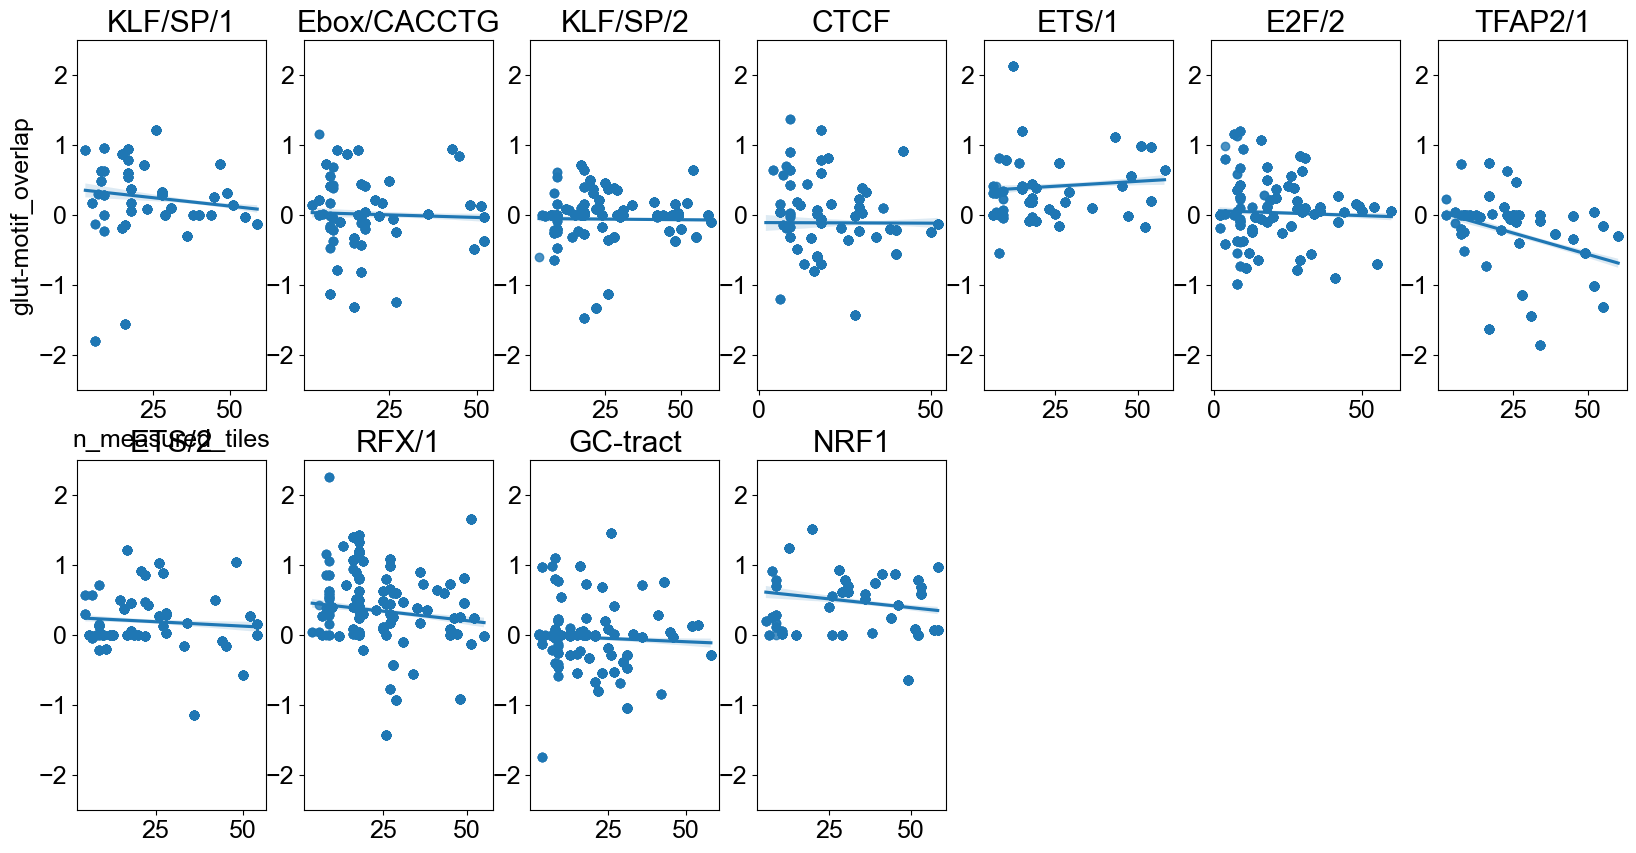

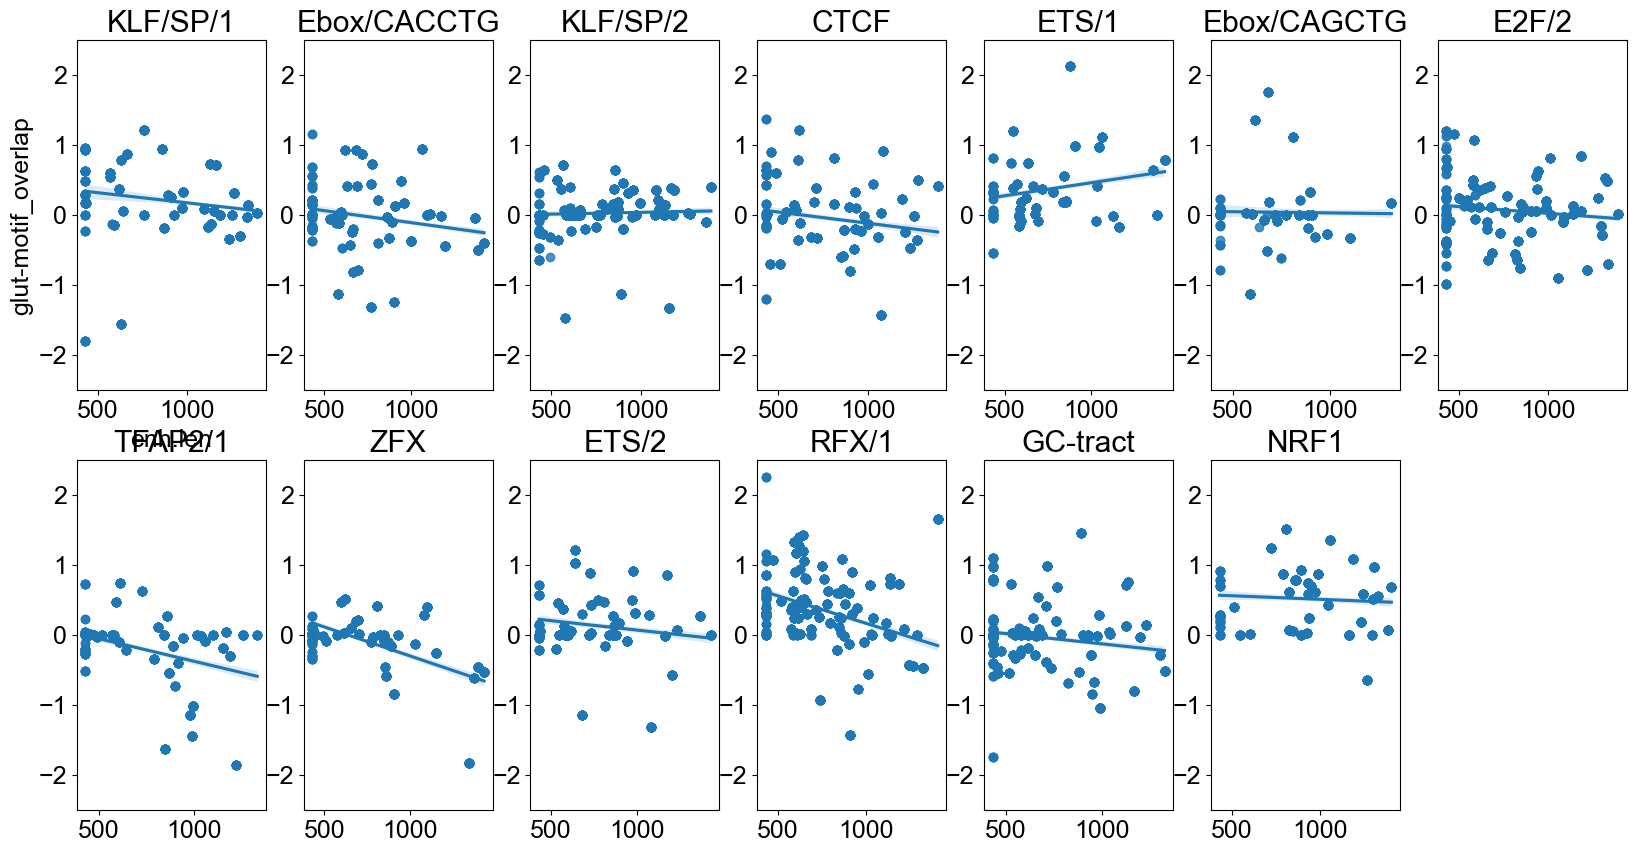

In [130]:
# n tiles measured or enh.len correlation

for metric  in ["n_measured_tiles", "enh.len"]:
    print(metric)
    v=0
    fig  = plt.figure(figsize=(20,10))
    metric_95pi = cfxlen[["enh.name", metric]].drop_duplicates()[metric].quantile(0.95)
    print(f"exclude top 95% of {metric}", round(metric_95pi))

    sampled = []
    for g in cfxlen["group"].unique():
        sampled.append(g)
        if str(g) != "nan":
            test = cfxlen.loc[(cfxlen["group"] == g) & (
                ~cfxlen['glut-motif_overlap'].isna())&
            (cfxlen[metric]<=metric_95pi)]
    
            if len(list(set(test[metric]))) >= 25:
                v += 1
                ax = plt.subplot(2,7,v)
                slope, intercept, r, p, se = stats.linregress(
                    x=test[metric], y=test['glut-motif_overlap'])
                print(g, slope, r, p)
    
                x=metric
                y='glut-motif_overlap'
                lm = sns.regplot(x=x, y=y, data=test, ax=ax)
                if v>1:
                    ax.set(title=g, ylabel="", xlabel="", ylim=(-2.5,2.5))
                else:
                    ax.set(title=g, ylim=(-2.5,2.5))
        out = os.path.join(RE, "tfbs_motifs", f"coeff_x_{metric}.pdf")
        plt.savefig(out, bbox_inches="tight")

## plot coefficients

In [ ]:
OVERLAP = "motif_nooverlap"
top_10 = list(cf.loc[cf['overlap_type']== OVERLAP].groupby(["tf"])["enh.name"].count().reset_index().sort_values(by="enh.name", ascending=False).head(10)["tf"])

fig, ax=plt.subplots(fisgsize=(6,10))
data=cf.loc[(cf['overlap_type']== OVERLAP)&(cf["tf"].isin(top_10))].sort_values(by="enh.coeff", ascending=True)
sns.violinplot(y="tf", x="enh.coeff", hue = "cell_type", data=data)
#sns.swarmplot(y="tf", x="enh.coeff", hue = "cell_type", data=data, dodge=True, legend=False)
ax.axvline(0, ls="--", color="grey")
ax.legend(frameon=False)
ax.set(title=OVERLAP)
out = os.path.join(RE, 'tfbs_motifs', f"TFBS_Coeffs_{OVERLAP}.pdf")
plt.savefig(out, bbox_inches='tight')

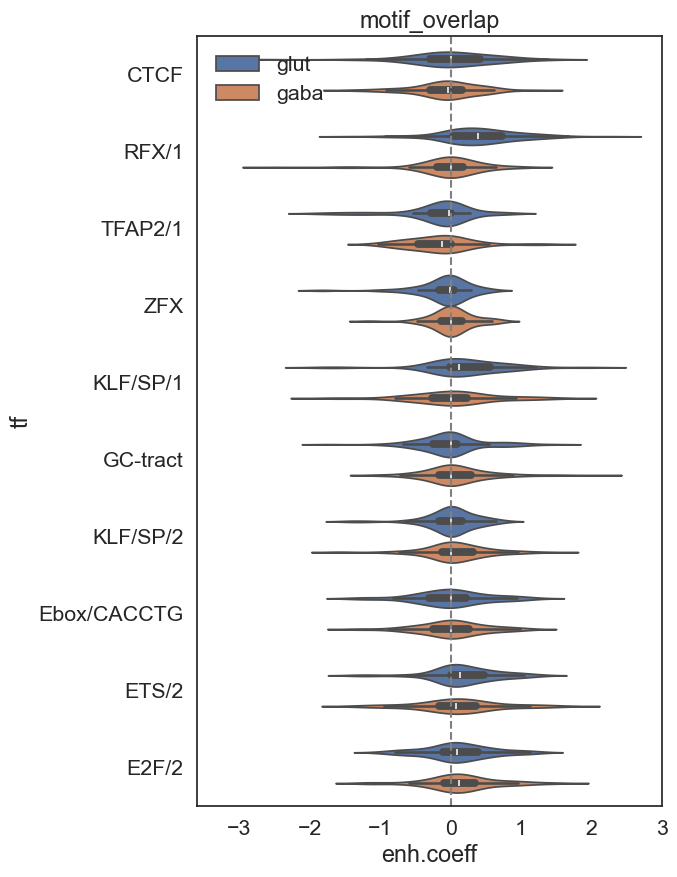

In [85]:
OVERLAP = "motif_overlap"
top_10 = list(cf.loc[cf['overlap_type']== OVERLAP].groupby(["tf"])["enh.name"].count().reset_index().sort_values(by="enh.name", ascending=False).head(10)["tf"])

fig, ax=plt.subplots(figsize=(6,10))
data=cf.loc[(cf['overlap_type']== OVERLAP)&(cf["tf"].isin(top_10))].sort_values(by="enh.coeff", ascending=True)
sns.violinplot(y="tf", x="enh.coeff", hue = "cell_type", data=data)
#sns.swarmplot(y="tf", x="enh.coeff", hue = "cell_type", data=data, dodge=True, legend=False)
ax.axvline(0, ls="--", color="grey")
ax.legend(frameon=False)
ax.set(title=OVERLAP)
out = os.path.join(RE, 'tfbs_motifs', f"TFBS_Coeffs_{OVERLAP}.pdf")
plt.savefig(out, bbox_inches='tight')

In [90]:
cf.loc[cf["enh.name"]=="enh.1530"]

,tf,enh.coeff,enh.name,cell_type,overlap_type
0,IRF/1,-0.895907,enh.1530,gaba,motif_nooverlap
0,IRF/1,0.295833,enh.1530,gaba,motif_overlap


In [22]:
tf_coeffs.drop_duplicates()

,name,enh.name,tile.order,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,...,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,gaba-motif_overlap,glut-motif_overlap,gaba-motif_nooverlap,glut-motif_nooverlap
0,chr1:10057-10327,enh.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1:10077-10347,enh.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1:10097-10367,enh.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1:10117-10387,enh.0,3.0,chr1,10117.0,10387.0,chr1,10386.0,10400.0,NR/3,...,14.0,False,269.0,283.0,True,10.7289,NaN,NaN,NaN,NaN
4,chr1:10133-10403,enh.0,4.0,chr1,10133.0,10403.0,chr1,10386.0,10400.0,NR/3,...,14.0,True,253.0,267.0,True,10.7289,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259515,chrY:19744428-19744698,enh.1825,19.0,chrY,19744428.0,19744698.0,chrY,19744706.0,19744720.0,NR/3,...,14.0,False,278.0,292.0,True,10.7289,NaN,0.076250,NaN,NaN
259516,chrY:19744428-19744698,enh.1825,19.0,chrY,19744428.0,19744698.0,chrY,19744700.0,19744713.0,NR/11,...,13.0,False,272.0,285.0,True,10.5229,NaN,NaN,NaN,NaN
259517,chrY:19744488-19744758,enh.1825,21.0,chrY,19744488.0,19744758.0,chrY,19744460.0,19744473.0,NFI/3,...,13.0,False,-28.0,-15.0,True,10.5229,NaN,NaN,NaN,NaN
259518,chrY:19744718-19744988,enh.1825,28.0,chrY,19744718.0,19744988.0,chrY,19744696.0,19744707.0,YY1,...,11.0,False,-22.0,-11.0,True,11.6052,0.10869,0.283159,-0.17757,NaN


# enrichment

            Y Feat | N Feat
    TFBS Y
    TFBS N

In [86]:
# remove shuffles, negative, positive, oligos,
# remove oligos that weren't measure in MPRA
clean = lib_mpra_dif.loc[(~lib_mpra_dif["name"].str.contains("shuf")) &
                         (~lib_mpra_dif["name"].str.contains("os")) &
                         (~lib_mpra_dif["name"].str.contains("eg")) &
                         (~lib_mpra_dif["sig"].isna())

                         ].copy()

In [87]:
## run enrichment per class

In [88]:
enrichment = {}
for feat in ["celltype_dif", "gaba-label", "glut-label"]:
    if feat=="celltype_dif":
        ft_true = clean.loc[clean[feat]==True, "name"]
        ft_false = clean.loc[clean[feat]==False, "name"]
    else:
        ft_true = clean.loc[clean[feat]!="False", "name"]
        ft_false = clean.loc[clean[feat]=="False", "name"]
    
    print(len(ft_true), len(ft_false))
    
    results = {} # collect FE results
    for tf_ in tf["group"].unique():  # parse archetypes
        
        if str(tf_) == "nan": # skip the nans
            continue
        tf_true = tf.loc[tf["group"]==tf_, "name"]  # tiles with tf 
        tf_false = tf.loc[tf["group"]!=tf_, "name"]  # tiles without tf
    
        if len(tf_true)>50:  # if archetype is represented in more than 50 tiles. 
            a = len(set(ft_true).intersection(set(tf_true)))  # feature and tf
            b = len(set(ft_false).intersection(set(tf_true)))  # not feature and tf
            c = len(set(ft_true).intersection(set(tf_false)))  # feature and not tf
            d = len(set(ft_false).intersection(set(tf_false)))  # not feature and  not tf
    
        table = [[a,b], [c,d]]
    
        bool, p=stats.fisher_exact(table)
        results[tf_] = [feat, tf_, a,b,c,d, bool, p]
    
    re = pd.DataFrame(np.vstack(results.values()))
    
    re.columns = ["feat", "tf", "a", "b", "c", "d", "OR", "p"]
    
    ## FDR correction
    re["bool"], re["fdr_p"] = fdrcorrection(re["p"].astype(float))
    print(re.loc[re["bool"]==True].sort_values(by="OR", ascending=False))
    enrichment[feat] = re
    

6225 27666
             feat          tf    a    b     c      d                  OR  \
20   celltype_dif         NFY  362  500  6212  27641  3.2215202833226013   
163  celltype_dif       CUX/2  133  184  6225  27665   3.212366858739305   
162  celltype_dif  CREB/ATF/1  133  184  6225  27665   3.212366858739305   
39   celltype_dif       RFX/2  196  272  6211  27638  3.2065074298919374   
77   celltype_dif         YY1  311  440  6217  27646  3.1431068770380337   
..            ...         ...  ...  ...   ...    ...                 ...   
228  celltype_dif       TBX/2    0   54  6225  27666                 0.0   
226  celltype_dif      ZNF490    0   54  6225  27666                 0.0   
225  celltype_dif      ZBTB49    0   54  6225  27666                 0.0   
143  celltype_dif    HINFP1/3    0   47  6225  27666                 0.0   
242  celltype_dif      ZNF232    0   54  6225  27666                 0.0   

                          p  bool         fdr_p  
20   3.6556936659220143e-5

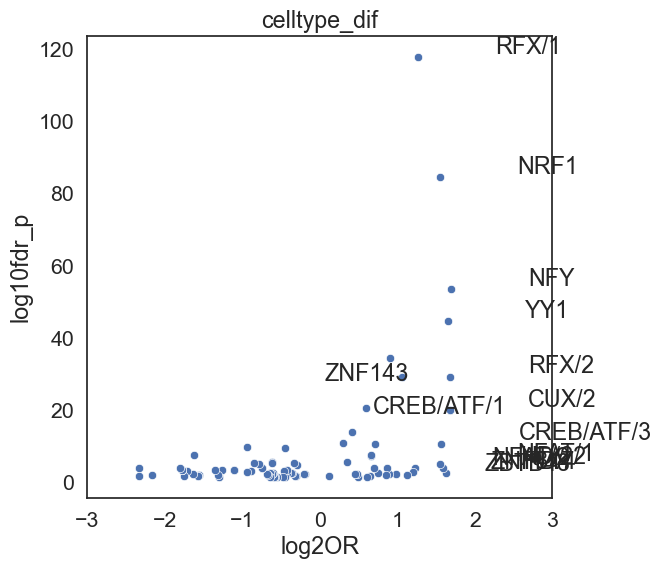

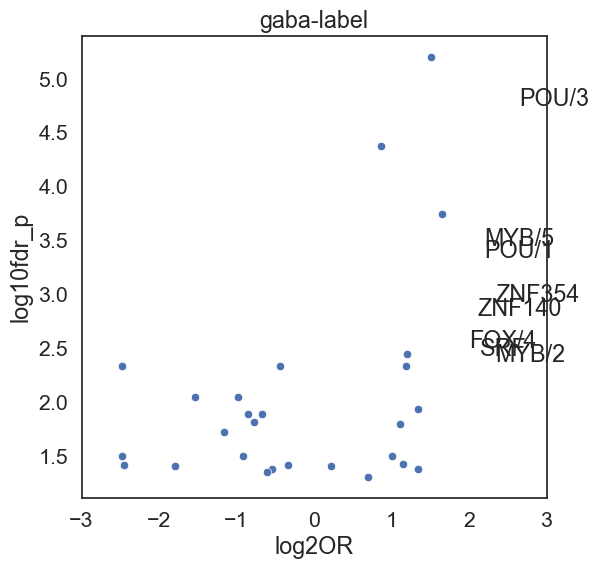

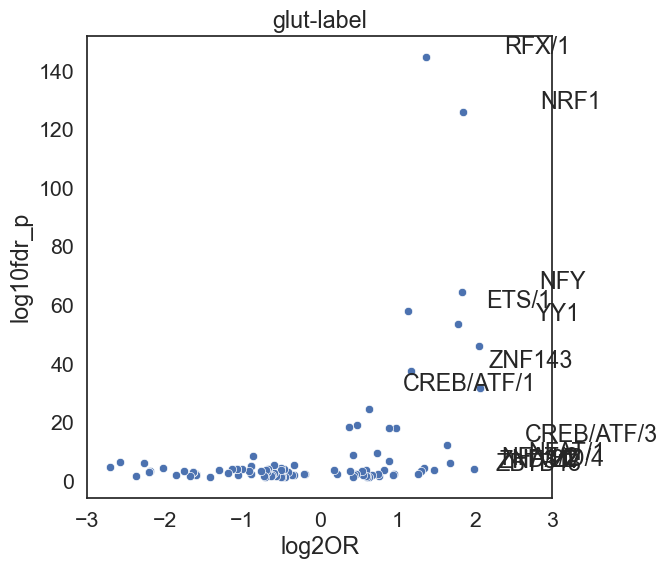

In [89]:
for feat in enrichment.keys():
    re = enrichment[feat]
    sig = re.loc[re["bool"]==True].sort_values(by="OR", ascending=False)
    sig['log10fdr_p'] = np.log10(sig["fdr_p"]) *-1
    sig["log2OR"] =  np.log2(sig["OR"].astype(float))
    
    fig, ax = plt.subplots(figsize=(6,6))
    x="log2OR"
    y="log10fdr_p"
    data=sig
    sns.scatterplot(x=x,y=y, data=data)

    seen_l10p=[]
    for row in data.iterrows():
        tf_, l2or, l10p = row[1]["tf"], row[1][x] , row[1][y]
        if l2or>1:
            if l10p not in seen_l10p: # prevent overlap on y axis
                adjust = 1
            else:
                adjust = -1
            ax.annotate(tf_,(l2or + adjust, l10p+ adjust))
            seen_l10p.append(l10p)
            
    ax.set(xlim=(-3,3), 
          title=feat, 
          )
    out = os.path.join(RE, 'tfbs_motifs', f"TFBS_enrichment_{feat}.pdf")
    plt.savefig(out, bbox_inches='tight')

In [ ]:
sig.loc[sig["log2OR"]>0].sort_values(by="fdr_p")

# archetype + models

In [ ]:
def group2Model(group_str, tf):
    """report the models aggregated in each archetype"""
    group_mapping = tf.loc[(tf["group"].str.contains(group_str)) &
                           (~tf["group"].isna())].groupby("group")["model"].unique().reset_index()


    for i in np.arange(group_mapping.shape[0]):
        print(group_mapping.iloc[i]["group"])
        print(group_mapping.iloc[i]["model"])

## investigate RFX types

In [ ]:
group2Model("RFX", tf)

In [ ]:
group2Model("NFY", tf)

In [ ]:
group2Model("POU", tf)